In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
spark = SparkSession.builder \
.appName("BostonHousingRegression") \
.getOrCreate()


df = spark.read.csv("/content/Boston House Price Data.csv", header=True, inferSchema=True)

df.printSchema()

df.show(5)

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: double (nullable = true)
 |-- TAX: double (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- PRICE: double (nullable = true)

+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+-----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|  TAX|PTRATIO|     B|LSTAT|PRICE|
+-------+----+-----+----+-----+-----+----+------+---+-----+-------+------+-----+-----+
|0.00632|18.0| 2.31| 0.0|0.538|6.575|65.2|  4.09|1.0|296.0|   15.3| 396.9| 4.98| 24.0|
|0.02731| 0.0| 7.07| 0.0|0.469|6.421|78.9|4.9671|2.0|242.0|   17.8| 396.9| 9.14| 21.6|
|0.02729| 0.0| 7.07| 0.0|0.469|7.185|61.1|4.9671|2.0|242.0|  

In [13]:
from pyspark.sql.functions import col, when, count, isnan

missing_per_col = df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c)
    for c in df.columns
])

missing_per_col.show()


+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+-----+
|CRIM| ZN|INDUS|CHAS|NOX| RM|AGE|DIS|RAD|TAX|PTRATIO|  B|LSTAT|PRICE|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+-----+
|   0|  0|    0|   0|  0|  0|  0|  0|  0|  0|      0|  0|    0|    0|
+----+---+-----+----+---+---+---+---+---+---+-------+---+-----+-----+



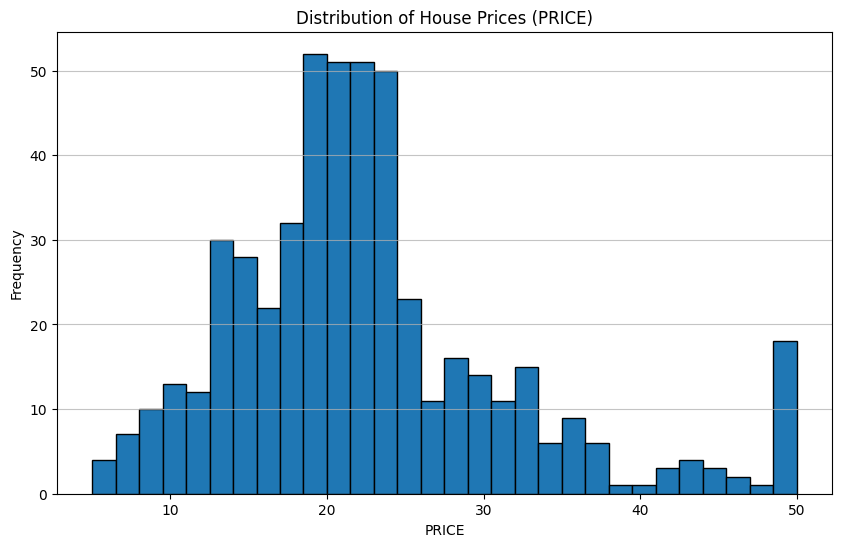

In [3]:
price_data = df.select("PRICE").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(price_data['PRICE'], bins=30, edgecolor='black')
plt.title('Distribution of House Prices (PRICE)')
plt.xlabel('PRICE')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

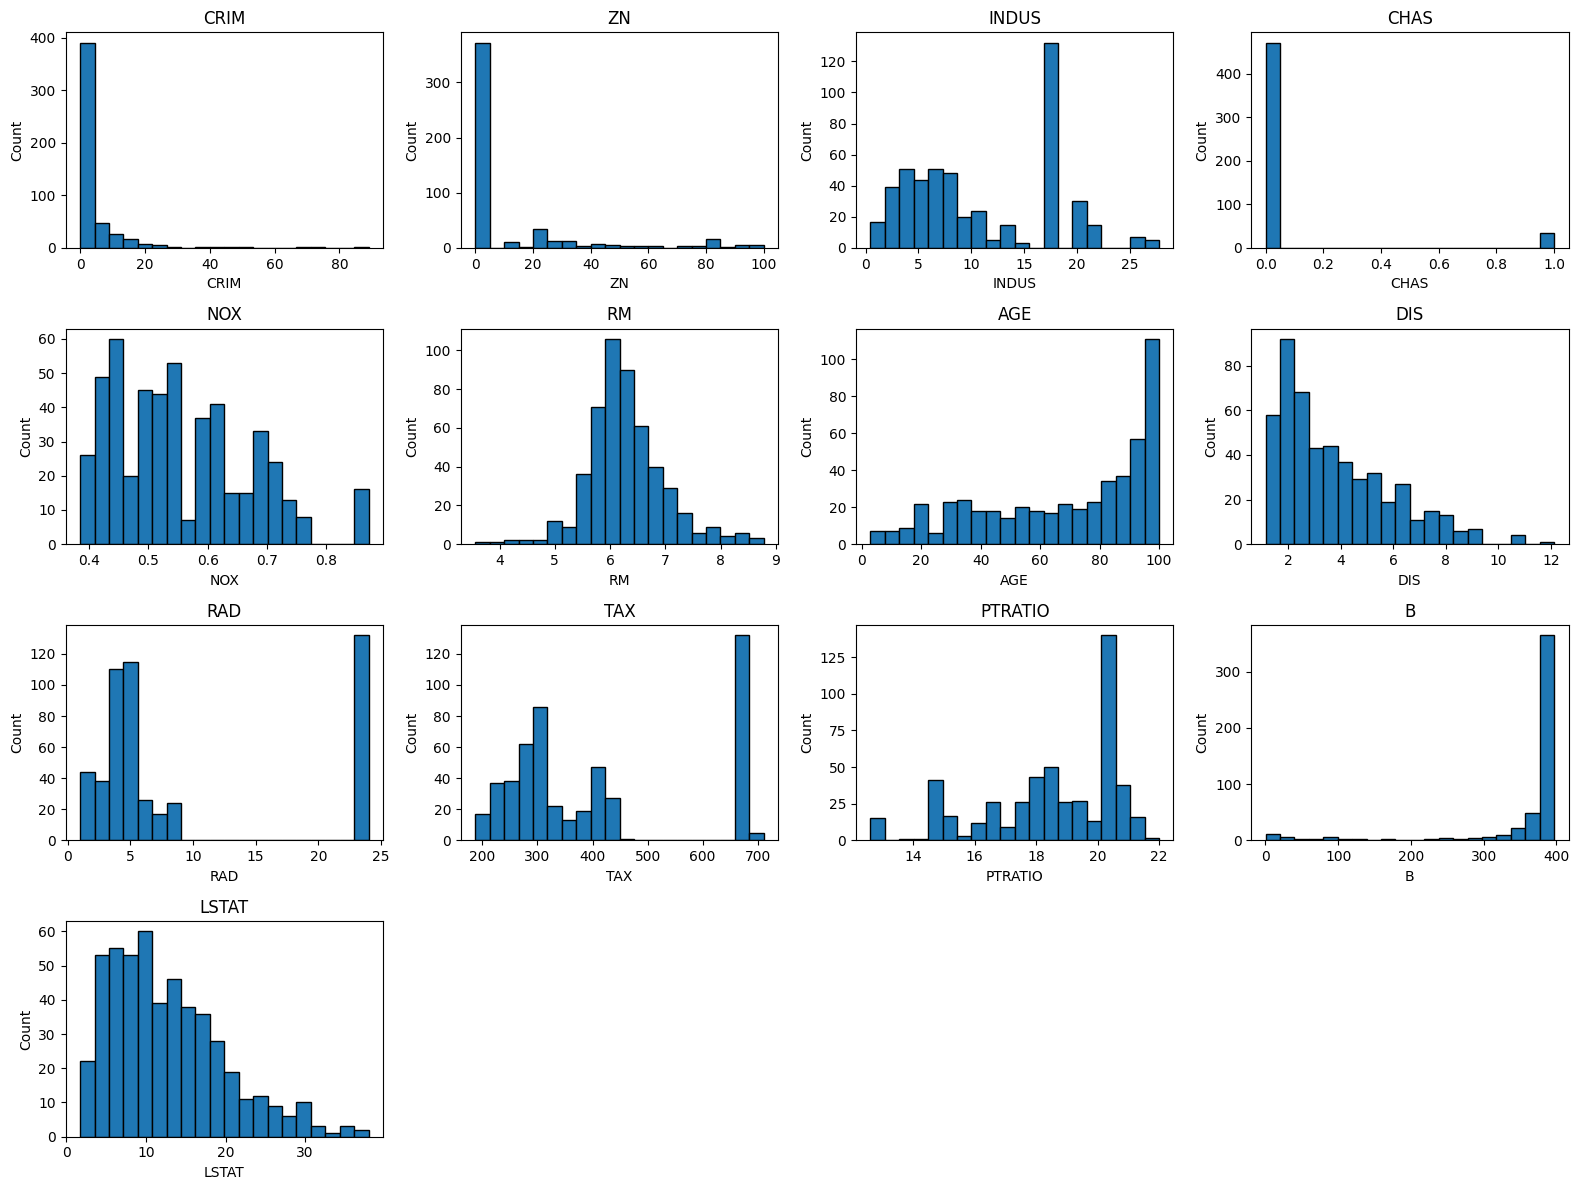

In [7]:
import matplotlib.pyplot as plt

pdf = df.toPandas()

feature_cols = ["CRIM", "ZN", "INDUS", "CHAS", "NOX",
                "RM", "AGE", "DIS", "RAD", "TAX",
                "PTRATIO", "B", "LSTAT"]

n_cols = 4
n_rows = (len(feature_cols) + n_cols - 1) // n_cols

plt.figure(figsize=(4 * n_cols, 3 * n_rows))

for i, col in enumerate(feature_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(pdf[col], bins=20, edgecolor="black")
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [21]:
from pyspark.sql.functions import col

target_column = "PRICE"


df_fe = (
    df
    .withColumn("RM_LSTAT", col("RM") * col("LSTAT"))
    .withColumn("NOX_INDUS", col("NOX") * col("INDUS"))
    .withColumn("DIS_RAD", col("DIS") * col("RAD"))
)

cols_to_drop = ["RM", "LSTAT", "NOX", "INDUS", "DIS", "RAD"]
df_fe = df_fe.drop(*cols_to_drop)

print("Full Data (after feature engineering):")
df_fe.printSchema()
df_fe.show(5, truncate=False)

train_df, val_df, test_df = df_fe.randomSplit([0.7, 0.15, 0.15], seed=42)

print("\nCounts after split:")
print(f"Train count      : {train_df.count()}")
print(f"Validation count : {val_df.count()}")
print(f"Test count       : {test_df.count()}")

print("\nSample from Train:")
train_df.show(5, truncate=False)



Full Data (after feature engineering):
root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- CHAS: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- TAX: double (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- PRICE: double (nullable = true)
 |-- RM_LSTAT: double (nullable = true)
 |-- NOX_INDUS: double (nullable = true)
 |-- DIS_RAD: double (nullable = true)

+-------+----+----+----+-----+-------+------+-----+------------------+------------------+-------+
|CRIM   |ZN  |CHAS|AGE |TAX  |PTRATIO|B     |PRICE|RM_LSTAT          |NOX_INDUS         |DIS_RAD|
+-------+----+----+----+-----+-------+------+-----+------------------+------------------+-------+
|0.00632|18.0|0.0 |65.2|296.0|15.3   |396.9 |24.0 |32.743500000000004|1.24278           |4.09   |
|0.02731|0.0 |0.0 |78.9|242.0|17.8   |396.9 |21.6 |58.687940000000005|3.31583           |9.9342 |
|0.02729|0.0 |0.0 |61.1|242.0|17.8   |392.83|34.7 |28.95555 

In [22]:
from pyspark.sql.functions import col, when, mean as _mean, stddev as _stddev

target_column = "PRICE"

numeric_cols = [c for c in train_df.columns if c != target_column]




bounds = {}

for c in numeric_cols:
    q1, q3 = train_df.approxQuantile(c, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    bounds[c] = (lower, upper)

def cap_outliers(df, bounds_dict):
    df_out = df
    for c, (lower, upper) in bounds_dict.items():
        df_out = df_out.withColumn(
            c,
            when(col(c) < lower, lower)
            .when(col(c) > upper, upper)
            .otherwise(col(c))
        )
    return df_out

train_cap = cap_outliers(train_df, bounds)
val_cap   = cap_outliers(val_df, bounds)
test_cap  = cap_outliers(test_df, bounds)

stats_row = train_cap.select(
    *[_mean(c).alias(f"{c}_mean") for c in numeric_cols],
    *[_stddev(c).alias(f"{c}_std") for c in numeric_cols]
).collect()[0]

def standardize(df, numeric_cols, stats):
    df_std = df
    for c in numeric_cols:
        mean_val = stats[f"{c}_mean"]
        std_val  = stats[f"{c}_std"]

        if std_val is None or std_val == 0:
            continue
        df_std = df_std.withColumn(
            c,
            (col(c) - mean_val) / std_val
        )
    return df_std

train_final = standardize(train_cap, numeric_cols, stats_row)
val_final   = standardize(val_cap, numeric_cols, stats_row)
test_final  = standardize(test_cap, numeric_cols, stats_row)

print("Train after outlier handling + standardization:")
train_final.show(5, truncate=False)


Train after outlier handling + standardization:
+-------------------+---+----+--------------------+-------------------+-------------------+------------------+-----+-------------------+-------------------+-------------------+
|CRIM               |ZN |CHAS|AGE                 |TAX                |PTRATIO            |B                 |PRICE|RM_LSTAT           |NOX_INDUS          |DIS_RAD            |
+-------------------+---+----+--------------------+-------------------+-------------------+------------------+-----+-------------------+-------------------+-------------------+
|-0.7602733459821444|0.0|0.0 |-0.14108165155768082|-0.6786722869777486|-1.4011284240424111|0.7832981720892795|24.0 |-1.1844432614640448|-1.1088139598815692|-1.2668632367633794|
|-0.758884208313969 |0.0|0.0 |-1.7232453585747516 |-0.7445051577330841|-1.4011284240424111|0.671830989485776 |32.2 |-0.574441421554388 |-1.1195633371856668|-1.0882275483422177|
|-0.7568816193397745|0.0|0.0 |-0.7076673033948753 |-0.7504899641653

In [25]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

target_column = "PRICE"

feature_cols = [c for c in train_final.columns if c != target_column]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

train_vec = assembler.transform(train_final).select("features", target_column)
val_vec   = assembler.transform(val_final).select("features", target_column)

lr = LinearRegression(featuresCol="features", labelCol=target_column)
dt = DecisionTreeRegressor(featuresCol="features", labelCol=target_column)
rf = RandomForestRegressor(featuresCol="features", labelCol=target_column)

lr_model = lr.fit(train_vec)
dt_model = dt.fit(train_vec)
rf_model = rf.fit(train_vec)

lr_train_pred = lr_model.transform(train_vec)
lr_val_pred   = lr_model.transform(val_vec)

dt_train_pred = dt_model.transform(train_vec)
dt_val_pred   = dt_model.transform(val_vec)

rf_train_pred = rf_model.transform(train_vec)
rf_val_pred   = rf_model.transform(val_vec)

rmse_eval = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")

print("\n=== Linear Regression ===")
print("Train RMSE:", rmse_eval.evaluate(lr_train_pred))
print("Val   RMSE:", rmse_eval.evaluate(lr_val_pred))
print("Train MAE :", mae_eval.evaluate(lr_train_pred))
print("Val   MAE :", mae_eval.evaluate(lr_val_pred))
print("Train R2  :", r2_eval.evaluate(lr_train_pred))
print("Val   R2  :", r2_eval.evaluate(lr_val_pred))

print("\n=== Decision Tree Regressor ===")
print("Train RMSE:", rmse_eval.evaluate(dt_train_pred))
print("Val   RMSE:", rmse_eval.evaluate(dt_val_pred))
print("Train MAE :", mae_eval.evaluate(dt_train_pred))
print("Val   MAE :", mae_eval.evaluate(dt_val_pred))
print("Train R2  :", r2_eval.evaluate(dt_train_pred))
print("Val   R2  :", r2_eval.evaluate(dt_val_pred))

print("\n=== Random Forest Regressor ===")
print("Train RMSE:", rmse_eval.evaluate(rf_train_pred))
print("Val   RMSE:", rmse_eval.evaluate(rf_val_pred))
print("Train MAE :", mae_eval.evaluate(rf_train_pred))
print("Val   MAE :", mae_eval.evaluate(rf_val_pred))
print("Train R2  :", r2_eval.evaluate(rf_train_pred))
print("Val   R2  :", r2_eval.evaluate(rf_val_pred))



=== Linear Regression ===
Train RMSE: 5.418104229077182
Val   RMSE: 6.565924445966754
Train MAE : 3.941855370974135
Val   MAE : 4.978956704130372
Train R2  : 0.6345813261426048
Val   R2  : 0.5381986634905735

=== Decision Tree Regressor ===
Train RMSE: 3.9385428741055284
Val   RMSE: 6.299597307366472
Train MAE : 2.7413528433070247
Val   MAE : 4.0534237162587745
Train R2  : 0.8069067104208746
Val   R2  : 0.5749020595405709

=== Random Forest Regressor ===
Train RMSE: 3.5150621295280784
Val   RMSE: 5.098707741011669
Train MAE : 2.4459372435079363
Val   MAE : 3.4748835671563203
Train R2  : 0.8461979805862347
Val   R2  : 0.7215266360298142


In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

target_column = "PRICE"

feature_cols = [c for c in train_final.columns if c != target_column]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

train_vec = assembler.transform(train_final).select("features", target_column)
val_vec   = assembler.transform(val_final).select("features", target_column)

rf_tuned = RandomForestRegressor(
    featuresCol="features",
    labelCol=target_column,
    numTrees=200,
    maxDepth=8,
    maxBins=32,
    minInstancesPerNode=2,
    featureSubsetStrategy="sqrt",
    seed=42
)

rf_tuned_model = rf_tuned.fit(train_vec)

rf_train_pred = rf_tuned_model.transform(train_vec)
rf_val_pred   = rf_tuned_model.transform(val_vec)

rmse_eval = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")

print("\n=== Random Forest Regressor (Tuned) ===")
print("Train RMSE:", rmse_eval.evaluate(rf_train_pred))
print("Val   RMSE:", rmse_eval.evaluate(rf_val_pred))
print("Train MAE :", mae_eval.evaluate(rf_train_pred))
print("Val   MAE :", mae_eval.evaluate(rf_val_pred))
print("Train R2  :", r2_eval.evaluate(rf_train_pred))
print("Val   R2  :", r2_eval.evaluate(rf_val_pred))



=== Random Forest Regressor (Tuned) ===
Train RMSE: 2.5513952779740126
Val   RMSE: 5.259373887935346
Train MAE : 1.7517350030708376
Val   MAE : 3.630838550337163
Train R2  : 0.9189689397909816
Val   R2  : 0.7037000930194248


In [27]:

test_vec = assembler.transform(test_final).select("features", target_column)


rf_test_pred = rf_tuned_model.transform(test_vec)

from pyspark.ml.evaluation import RegressionEvaluator

rmse_eval = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
mae_eval  = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="mae")
r2_eval   = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="r2")

print("\n=== Random Forest Regressor – Test Performance ===")
print("Test RMSE:", rmse_eval.evaluate(rf_test_pred))
print("Test MAE :", mae_eval.evaluate(rf_test_pred))
print("Test R2  :", r2_eval.evaluate(rf_test_pred))



=== Random Forest Regressor – Test Performance ===
Test RMSE: 3.605787479283807
Test MAE : 2.5953230401846024
Test R2  : 0.8699429076615571
